# LLAMA 13B instruction using LMI container on SageMaker
In this tutorial, you will bring your own container from docker hub to SageMaker and run inference with it.
Please make sure the following permission granted before running the notebook:

- ECR Push/Pull access
- S3 bucket push access
- SageMaker access

## Step 1: Let's bump up SageMaker and import stuff

In [1]:
#%pip install sagemaker boto3 awscli --upgrade  --quiet

In [2]:
%pip install sagemaker boto3 awscli --upgrade 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached awscli-1.27.137-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.136-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.135-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.134-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.133-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.132-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.131-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.130-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.129-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.128-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.127-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.126-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.125-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.124-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.123-py3-none-any.whl (4.1 MB)
  Using cached awscli-1.27.122-py3-none-any.whl (4.1 MB)
  Us

In [3]:
import boto3
import sagemaker
from sagemaker import Model, serializers, deserializers

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()  # account_id of the current SageMaker Studio environment

In [4]:
print(role, region, account_id)

arn:aws:iam::328296961357:role/service-role/AmazonSageMaker-ExecutionRole-20191125T182032 us-west-2 328296961357


In [5]:
sagemaker.__version__

'2.157.0'

## Step 2 pull and push the docker from Docker hub to ECR repository

*Note: Please make sure you have the permission in AWS credential to push to ECR repository*

This process may take a while, depends on the container size and your network bandwidth

In [6]:
%%sh

# The name of our container
repo_name=djlserving-byoc
# Target container
target_container="deepjavalibrary/djl-serving:0.22.1-deepspeed"

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${repo_name}:latest"
echo "Creating ECR repository ${fullname}"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${repo_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${repo_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
aws ecr get-login-password --region ${region} | docker login --username AWS --password-stdin "${account}.dkr.ecr.${region}.amazonaws.com"

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
echo "Start pulling container: ${target_container}"

docker pull ${target_container}
docker tag ${target_container} ${fullname}
docker push ${fullname}

Creating ECR repository 328296961357.dkr.ecr.us-west-2.amazonaws.com/djlserving-byoc:latest
Login Succeeded
Start pulling container: deepjavalibrary/djl-serving:0.22.1-deepspeed
0.22.1-deepspeed: Pulling from deepjavalibrary/djl-serving
Digest: sha256:63b87ffa887e8925f044cd3aefb3fafcf58a588d0c027bcf9e9c9dcc910c69c8
Status: Image is up to date for deepjavalibrary/djl-serving:0.22.1-deepspeed
docker.io/deepjavalibrary/djl-serving:0.22.1-deepspeed
The push refers to repository [328296961357.dkr.ecr.us-west-2.amazonaws.com/djlserving-byoc]
d4d1ed5f2dbe: Preparing
d11a6221e874: Preparing
cbc7ce41ca31: Preparing
130cdcc3547d: Preparing
359ab0c2f0dc: Preparing
01224703e9ac: Preparing
4db5b9adca6e: Preparing
daa5ca040bcc: Preparing
6fd7b734e603: Preparing
6ac132af81cf: Preparing
564b6b099959: Preparing
d3f39a7d0728: Preparing
248e04462435: Preparing
dda19c4c8c6a: Preparing
5168960dee2f: Preparing
7af37e3e56a9: Preparing
e5167e76bf1b: Preparing
a490a70ab1cd: Preparing
b3c248c52364: Preparing
d5

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



## Step 3: Start preparing model artifacts
In LMI contianer, we expect some artifacts to help setting up the model
- serving.properties (required): Defines the model server settings
- model.py (optional): A python file to define the core inference logic
- requirements.txt (optional): Any additional pip wheel need to install

In [7]:
%%writefile serving.properties
engine=DeepSpeed
option.tensor_parallel_degree=2
#option.tensor_parallel_degree=1
option.model_id=openlm-research/open_llama_7b_400bt_preview
#option.model_id=huggyllama/llama-7b
#option.model_id=huggyllama/llama-13b
#option.model_id=s3://lmi-customer-drop/StabilityAI/llama-13b-sft-self-critiquing-base/

Writing serving.properties


In [8]:
%%writefile model.py
from djl_python import Input, Output
from djl_python.streaming_utils import StreamingUtils
import os
import deepspeed
import torch
import logging
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from transformers.models.llama.modeling_llama import LlamaDecoderLayer
##
from transformers import LlamaTokenizer, LlamaForCausalLM

model = None
tokenizer = None


def get_model(properties):
    model_name = properties["model_id"]
    tensor_parallel_degree = properties["tensor_parallel_degree"]
    max_tokens = int(properties.get("max_tokens", "1024"))
    dtype = torch.float16

    model = LlamaForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map='auto')
    tokenizer = LlamaTokenizer.from_pretrained(model_path)
    
#    model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True, torch_dtype=dtype)
#    tokenizer = AutoTokenizer.from_pretrained(model_name) 
    tokenizer.pad_token = tokenizer.eos_token
    
    model = deepspeed.init_inference(model,
                                           tensor_parallel={"tp_size": tensor_parallel_degree},
                                           max_tokens=max_tokens,
                                           dtype=model.dtype,
                                           injection_policy={LlamaDecoderLayer: ('self_attn.o_proj', 'mlp.down_proj')})
    return model, tokenizer


def inference(inputs):
    try:
        input_map = inputs.get_as_json()
        data = input_map.pop("inputs", input_map)
        parameters = input_map.pop("parameters", {})
        outputs = Output()

        enable_streaming = inputs.get_properties().get("enable_streaming",
                            "false").lower() == "true"
        if enable_streaming:
            stream_generator = StreamingUtils.get_stream_generator(
                "DeepSpeed")
            outputs.add_stream_content(
                stream_generator(model, tokenizer, data,
                                 **parameters))
            return outputs

        input_tokens = tokenizer(data, padding=True,
                                return_tensors="pt").to(
                                torch.cuda.current_device())
        with torch.no_grad():
            output_tokens = model.generate(input_tokens.input_ids, **parameters)
        generated_text = tokenizer.batch_decode(output_tokens,
                                        skip_special_tokens=True)

        outputs.add_as_json([{"generated_text": s} for s in generated_text])
        return outputs
    except Exception as e:
        logging.exception("Huggingface inference failed")
        # error handling
        outputs = Output().error(str(e))



def handle(inputs: Input) -> None:
    global model, tokenizer
    if not model:
        model, tokenizer = get_model(inputs.get_properties())

    if inputs.is_empty():
        # Model server makes an empty call to warmup the model on startup
        return None

    return inference(inputs)

Writing model.py


In [9]:
%%writefile requirements.txt
transformers==4.28.1

Writing requirements.txt


In [10]:
%%sh
mkdir mymodel
mv serving.properties mymodel/
mv model.py mymodel/
mv requirements.txt mymodel/
tar czvf mymodel.tar.gz mymodel/
rm -rf mymodel

mymodel/
mymodel/requirements.txt
mymodel/model.py
mymodel/serving.properties


## Step 4: Start building SageMaker endpoint
In this step, we will build SageMaker endpoint from scratch

### 4.1 Upload artifact on S3 and create SageMaker model

In [11]:
s3_code_prefix = "large-model-lmi/code"
bucket = sess.default_bucket()  # bucket to house artifacts
code_artifact = sess.upload_data("mymodel.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact}")

repo_name="djlserving-byoc"
image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{repo_name}:latest"

model = Model(image_uri=image_uri, model_data=code_artifact, role=role)

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-328296961357/large-model-lmi/code/mymodel.tar.gz


### 4.2 Create SageMaker endpoint

You need to specify the instance to use and endpoint names

In [12]:
instance_type = "ml.g5.12xlarge"
#instance_type = "ml.g4dn.8xlarge"

endpoint_name = sagemaker.utils.name_from_base("open-llama-lmi-model")

model.deploy(initial_instance_count=1,
             instance_type=instance_type,
             endpoint_name=endpoint_name,
             container_startup_health_check_timeout=900)

# our requests and responses will be in json format so we specify the serializer and the deserializer
predictor = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=deserializers.JSONDeserializer(),
)

----------------------------------------*

UnexpectedStatusException: Error hosting endpoint open-llama-lmi-model-2023-05-20-01-41-38-950: Failed. Reason: The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

## Step 5: Test and benchmark the inference

In [ ]:
predictor.predict(
    {"inputs": "Large model inference is", "parameters": {"max_new_tokens": 256}}
)

## Let us define a helper function to get a histogram of invocation latency distribution

In [15]:
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm

def _latency_hist_plot(endpoint_name, invocation_number=100):
    latency_array = []
    for i in tqdm(range(invocation_number)):
        tic = time.time()
        response_ = predictor.predict(
                        {"inputs": "Large model inference is", "parameters": {"max_new_tokens": 256}}
                    )
        toc = time.time()
        latency_array.append(toc-tic)
        
    latency_array_np = np.array(latency_array)
    _ = plt.hist(latency_array_np, bins='auto')  # arguments are passed to np.histogram
    plt.title("Invocation Latency Histogram with 'auto' bins")
    plt.show()

100%|██████████| 100/100 [25:31<00:00, 15.31s/it]


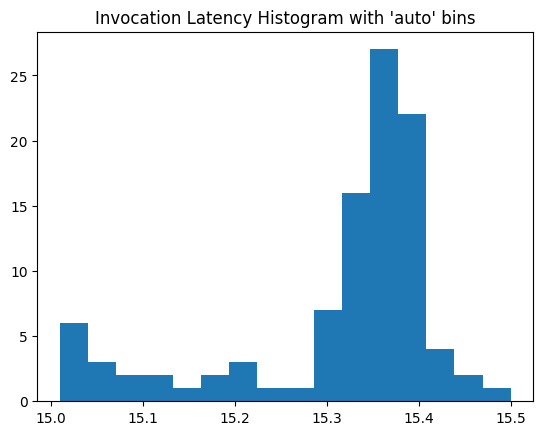

CPU times: user 767 ms, sys: 104 ms, total: 871 ms
Wall time: 25min 31s


In [16]:
%%time

invocation_number = 100
# Real-time endpoint
_latency_hist_plot(endpoint_name, invocation_number)

## Clean up the environment

In [17]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
model.delete_model()

In [27]:
#pausing execution for 15 seconds so that the endpoint gets deleted. 
#Otherwise, we may run into account instance limits.
from time import sleep
sleep(15)

## MME deployment

In [18]:
#Ref: https://github.com/aws/amazon-sagemaker-examples/blob/main/advanced_functionality/multi_model_xgboost_home_value/xgboost_multi_model_endpoint_home_value.ipynb

In [19]:
%%sh
cp mymodel.tar.gz mymodel-1.tar.gz
cp mymodel.tar.gz mymodel-2.tar.gz

In [20]:
from sagemaker.multidatamodel import MultiDataModel

In [21]:
# This is where our MME will read models from on S3.
#s3://sagemaker-us-west-2-328296961357/large-model-lmi/code/mymodel.tar.gz
#mme_instance_type = "ml.g5.12xlarge"
#mme_instance_type = "ml.g5.24xlarge"
mme_instance_type = "ml.g4dn.8xlarge"
#ml.g4dn.16xlarge 
mme_endpoint_name = sagemaker.utils.name_from_base("lmi-mme")
s3_mme_code_prefix = "large-model-lmi/mme/code"
bucket = sess.default_bucket()  # bucket to house artifacts
model_1_code_artifact = sess.upload_data("mymodel-1.tar.gz", bucket, s3_mme_code_prefix)
model_2_code_artifact = sess.upload_data("mymodel-2.tar.gz", bucket, s3_mme_code_prefix)

print(f"S3 Code or Model tar ball uploaded to --- > {model_1_code_artifact}")
print(f"S3 Code or Model tar ball uploaded to --- > {model_2_code_artifact}")


mme_data_prefix = f"s3://{bucket}/{s3_mme_code_prefix}/"
print(mme_data_prefix)
print(mme_endpoint_name)

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-328296961357/large-model-lmi/mme/code/mymodel-1.tar.gz
S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-328296961357/large-model-lmi/mme/code/mymodel-2.tar.gz
s3://sagemaker-us-west-2-328296961357/large-model-lmi/mme/code/
lmi-mme-2023-05-18-03-10-45-752


In [30]:
mme = MultiDataModel(
    name=mme_endpoint_name,
    model_data_prefix=mme_data_prefix,
    model=model,  # passing our model - passes container image needed for the endpoint
    sagemaker_session=sess,
)

In [31]:
mme.deploy(
    initial_instance_count=1, instance_type=mme_instance_type, endpoint_name=mme_endpoint_name, 
    container_startup_health_check_timeout=900
)

Using already existing model: lmi-mme-2023-05-18-03-10-45-752


----------!

In [32]:
# our requests and responses will be in json format so we specify the serializer and the deserializer
mme_predictor = sagemaker.Predictor(
    endpoint_name=mme_endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=deserializers.JSONDeserializer(),
)

In [33]:
# No models visible!
list(mme.list_models())

['mymodel-1.tar.gz', 'mymodel-2.tar.gz']

mme.add_model(model_data_source=s3_mme_code_prefix, model_data_path=model_1_code_artifact)
mme.add_model(model_data_source=s3_mme_code_prefix, model_data_path=model_2_code_artifact)

predicted_value = predictor.predict(data=gen_random_house()[1:], target_model="Chicago_IL.tar.gz")

In [34]:
mme_predictor.predict(
    data={"inputs": "Large model inference is", "parameters": {"max_new_tokens": 256}}, target_model="mymodel-1.tar.gz"
)

[{'generated_text': 'Large model inference is a challenging problem in machine learning. In this paper, we propose a novel approach to large model inference, which is based on the idea of model-based optimization. We first introduce a novel model-based optimization algorithm, which is able to efficiently optimize a large model with a small number of samples. Then, we propose a novel large model inference algorithm, which is based on the model-based optimization algorithm. The proposed large model inference algorithm is able to efficiently infer a large model with a small number of samples. We conduct extensive experiments on a variety of large models, including deep neural networks, and show that the proposed large model inference algorithm is able to achieve state-of-the-art performance.\nThis work was supported in part by the National Science Foundation under Grant No. 1522276, the National Science Foundation under Grant No. 1522276, the National Science Foundation under Grant No. 15

In [36]:
mme_predictor.predict(
    data={"inputs": "BARD Large model inference is", "parameters": {"max_new_tokens": 256}}, target_model="mymodel-2.tar.gz"
)

[{'generated_text': 'BARD Large model inference is a software package for the analysis of large-scale models. It is based on the BARD software package for the analysis of small-scale models.\nThe BARD Large model inference package is a software package for the analysis of large-scale models. It is based on the BARD software package for the analysis of small-scale models.\nThe BARD Large model inference package is a software package for the analysis of large-scale models. It is based on the BARD software package for the analysis of small-scale models. The BARD Large model inference package is a software package for the analysis of large-scale models. It is based on the BARD software package for the analysis of small-scale models.\nThe BARD Large model inference package is a software package for the analysis of large-scale models. It is based on the BARD software package for the analysis of small-scale models. The BARD Large model inference package is a software package for the analysis 